In [24]:
from my_sde import *

In [25]:
# Training
n_epochs = 10000
batch_size = 512
learning_rate = 2.0e-4
n_nodes = 14

beta_min = 0.001
beta_max = 0.5

# Sample
num_nodes = n_nodes
num_epochs = n_epochs
beta_min_ = beta_min
beta_max_ = beta_max

n_samples = 50000
num_steps = 10000

# model
Model = MLP_noise
n_std = 0.1
n_lim = 0.2
NN_amp = 5

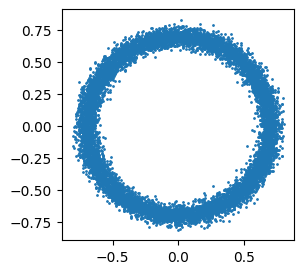

In [26]:
mean_s = 0.7
std_s = 0.04
r_s = torch.randn(10000) * std_s + mean_s
rad_s = torch.rand(10000) * 2 * np.pi
x_s = r_s * torch.cos(rad_s)
y_s = r_s * torch.sin(rad_s)
dataset = torch.stack([x_s, y_s], dim=1).to(device)

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(*(dataset.cpu().numpy().T), s=1)
fig.show()

## Training

In [20]:
score_model = Model(n_node=n_nodes, 
                    n_std=n_std, n_lim=n_lim, 
                    amp=NN_amp).cuda(device)
sde = VPSDE(score_model, beta_min=beta_min, beta_max=beta_max)

data_train = dataset[:,None]
dataloader = torch.utils.data.DataLoader(data_train.to(device), batch_size=batch_size, shuffle=True)

# alpha: saturation coefficient
# lambda_: regularization coefficient
loss_ls = sde.train(dataloader, n_epochs, 
                    learning_rate, 
                    alpha=1e-7,
                    lambda_=3e-5,) 

Loss: 0.679: 100%|██████████| 10000/10000 [08:53<00:00, 18.73it/s]


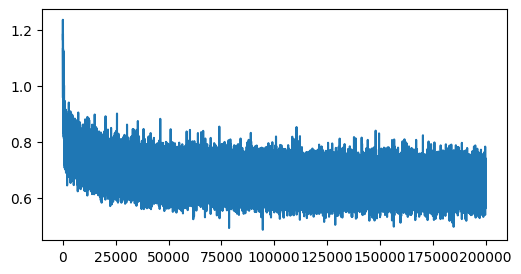

In [21]:
plt.figure(figsize=(6, 3))
plt.plot(loss_ls)
plt.show()

# saving model
file_save = f'model.pth'
torch.save(score_model.state_dict(), file_save)

## Sample one

In [22]:
Model = MLP
model_file_path = f'model.pth'

score_model_load = Model(n_node=num_nodes, amp=NN_amp).cuda(device)
model_statedict = torch.load(model_file_path, map_location=device)
score_model_load.load_state_dict(model_statedict)

scale = 2
sde = VPSDE(score_model_load, beta_min=beta_min_*scale, beta_max=beta_max_*scale)

euler_ode采样耗时1.60s


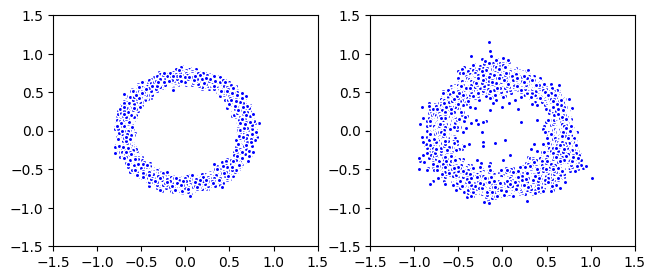

In [23]:
s_type = 'euler_ode'    # 'euler', 'euler_ode'
points = sde.sample(n_samples, num_steps, type=s_type, dim=2)

fig, ax = plt.subplots(figsize=(7.5, 3))
plt.clf()                                  # clears the entire current figure
plt.subplot(121)
plt.scatter(*(dataset.cpu().numpy().T), color='blue', edgecolor='white', s=10)
lim = 1.5
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.subplot(122)
plt.scatter(*(points.cpu().numpy().T), color='blue', edgecolor='white', s=10)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
fig.show()